In [1]:
import numpy as np
import pandas as pd
import import_ipynb
import pair_selection_DBSCAN_func as myFunc
import matplotlib.pyplot as plt

import math
import sklearn
import datetime

from sklearn import datasets, linear_model
from sklearn.preprocessing import PolynomialFeatures

importing Jupyter notebook from pair_selection_DBSCAN_func.ipynb


NameError: name 'price_df' is not defined

In [6]:
price_df = pd.read_csv('./Data/us_etf_price.csv')
etf_info = pd.read_csv('./Data/etfs_details_equity.csv')

FileNotFoundError: [Errno 2] No such file or directory: './Data/us_etf_price.csv'

In [8]:
start_date = '2015-01-01'
end_date = '2015-07-01'

test_start_date = '2015-07-01'
test_end_date = '2015-08-01'

pc_selecting_threshold = 0.9
eps = 1.8
min_samples = 4
cluster_size_limit = 100
cluster_member_counts = 100
inverse_threshold=-0.99
coint_pvalue_threshold=0.02
hurst_threshold=0.5
half_life_threshold=10
mean_reverting_freq=12

the number of ETF:  779


100%|██████████| 779/779 [00:03<00:00, 196.07it/s]
/Users/yjban/tensorflow/env/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(


Clusters discovered: 18
Clusters formed: 17
Pairs to evaluate: 656


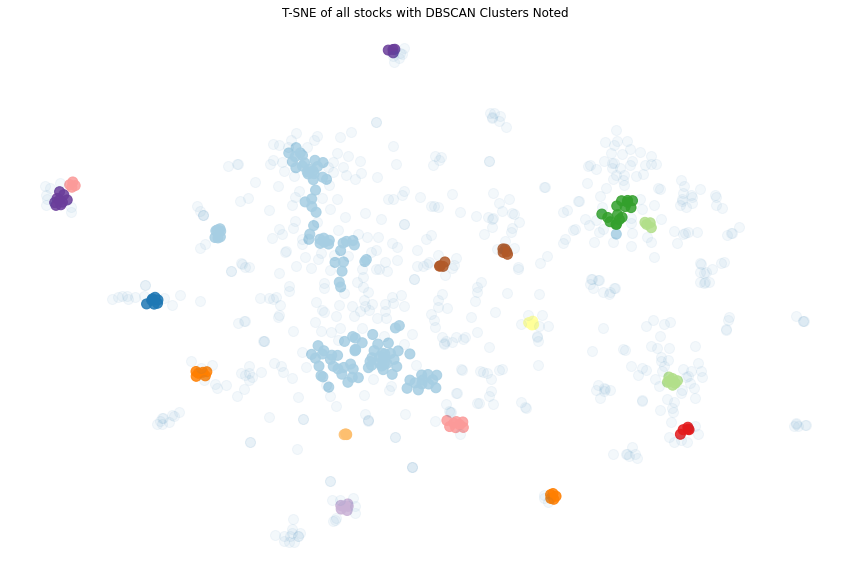

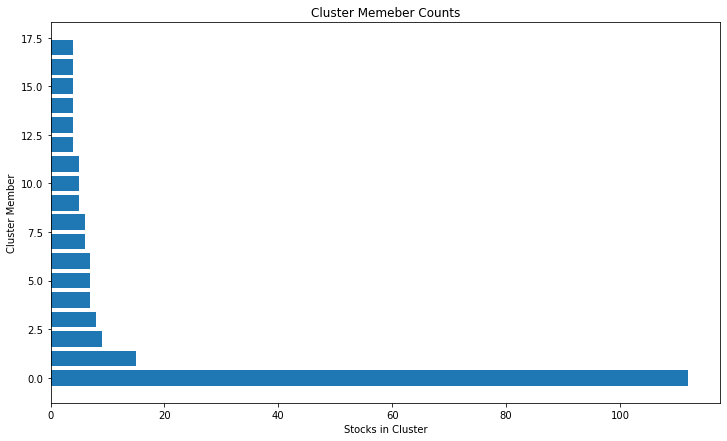

final_clusters index :  [17, 4, 13, 9, 7, 15, 8, 11, 16, 12, 10, 1, 3, 2, 6, 14, 5]


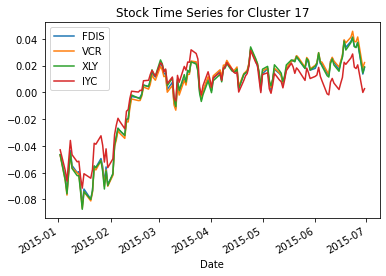

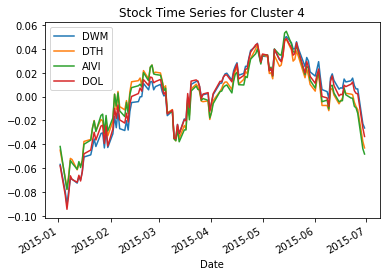

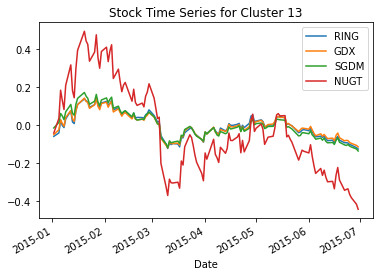

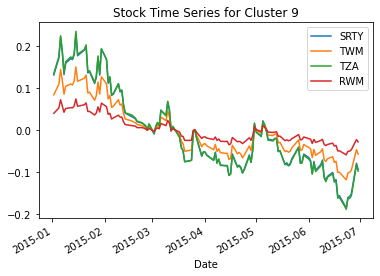

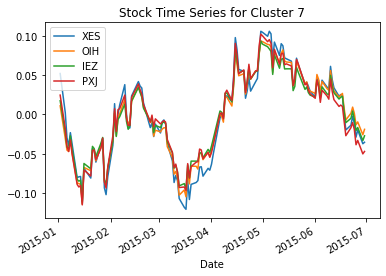

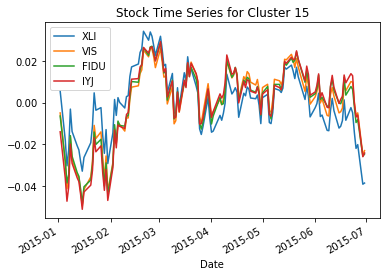

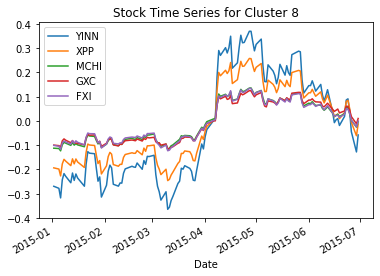

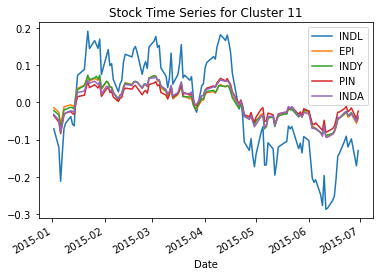

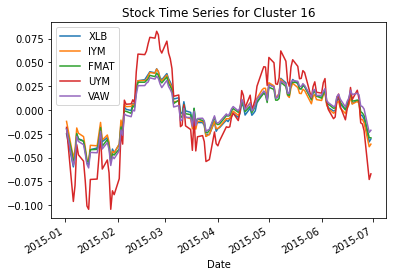

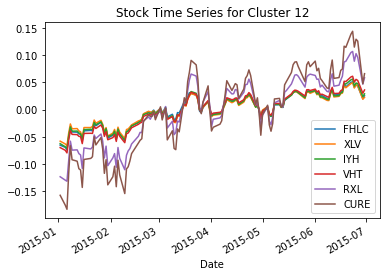

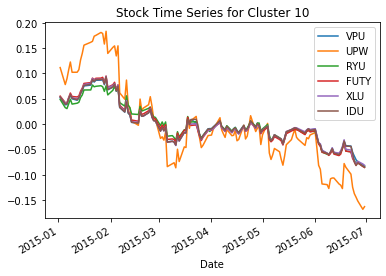

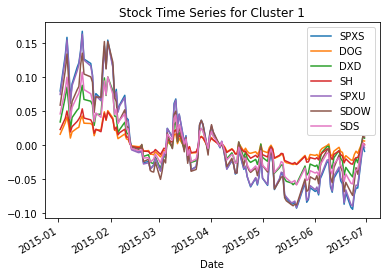

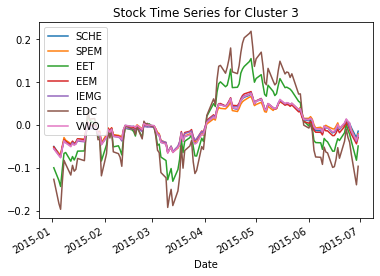

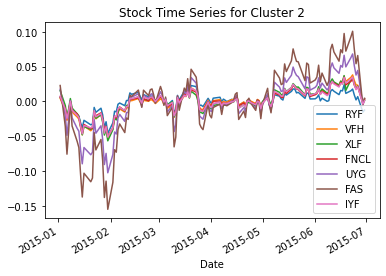

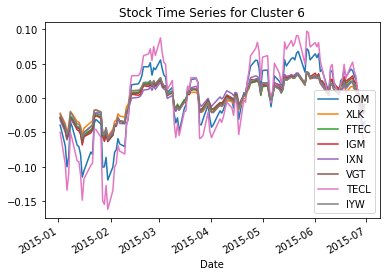

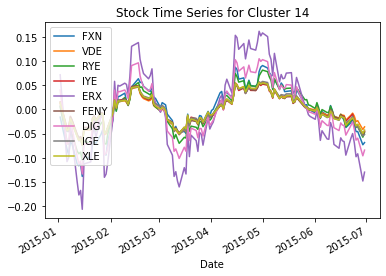

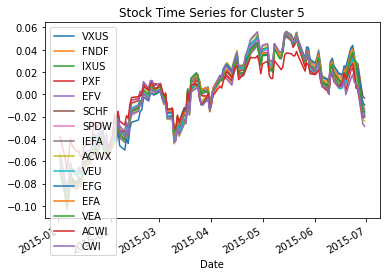

0it [00:00, ?it/s]/17 [00:00<?, ?it/s]
0it [00:00, ?it/s]/17 [00:00<00:07,  2.22it/s]
100%|██████████| 6/6 [00:00<00:00, 367.26it/s]
0it [00:00, ?it/s]/17 [00:02<00:09,  1.44it/s]
0it [00:00, ?it/s]/17 [00:02<00:07,  1.65it/s]
100%|██████████| 3/3 [00:00<00:00, 319.59it/s]
0it [00:00, ?it/s]/17 [00:04<00:06,  1.50it/s]
100%|██████████| 1/1 [00:00<00:00, 222.27it/s]
0it [00:00, ?it/s]/17 [00:05<00:05,  1.46it/s]
0it [00:00, ?it/s]0/17 [00:06<00:04,  1.47it/s]
100%|██████████| 15/15 [00:00<00:00, 410.29it/s]
0it [00:00, ?it/s]6/17 [00:14<00:01,  1.39s/it]
100%|██████████| 17/17 [00:16<00:00,  1.06it/s]


[[('XLK', 'TECL')]]
pairs = ([('XLK', 'TECL')])



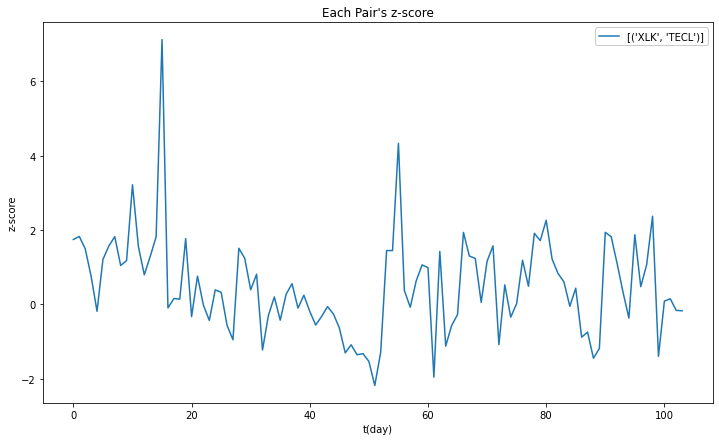

best_earning_ratio is:  1.0872267944420235
the number of ETF:  815


100%|██████████| 815/815 [00:02<00:00, 350.26it/s] 


pairs = ([('XLK', 'TECL')])



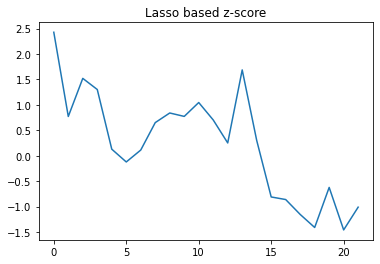

============ test result ==============
1.0583519666017467


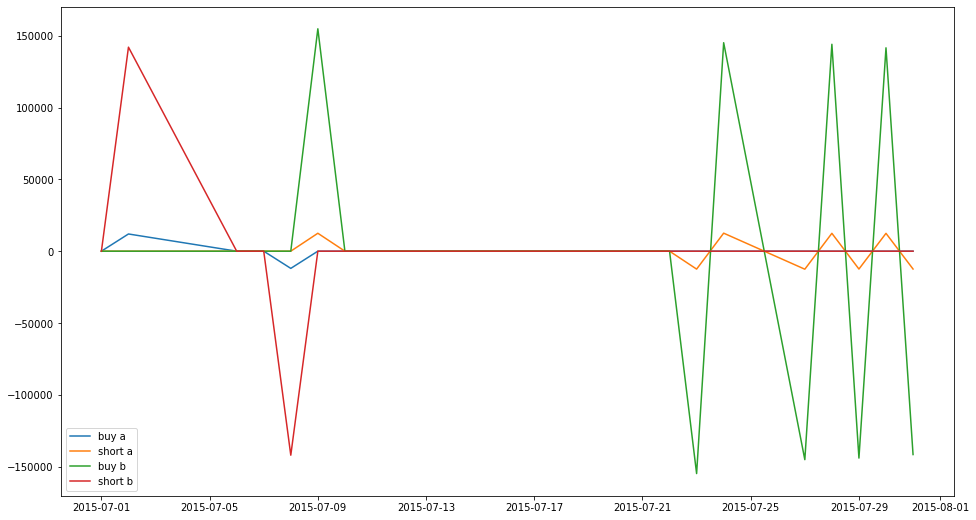

In [9]:
def get_pair(start_date, end_date):

    _, close_df, rtn_df, low_volume_etf = myFunc.preprocessing(price_df,etf_info, start_date, end_date)
    pc_rtn = myFunc.get_pca_return(rtn_df, pc_selecting_threshold)
    clusters_viz_list, clustered_series = myFunc.dbscan_clustering(close_df, pc_rtn, eps, min_samples, cluster_size_limit, cluster_member_counts)
    selected_pair, short_pair = myFunc.Pair_selection(close_df=close_df,
                                                rtn_df=rtn_df,
                                                low_volume_etf=low_volume_etf,
                                                clusters_viz_list=clusters_viz_list, 
                                                clustered_series=clustered_series, 
                                                inverse_threshold=inverse_threshold, 
                                                coint_pvalue_threshold=coint_pvalue_threshold, 
                                                hurst_threshold=hurst_threshold, 
                                                half_life_threshold=half_life_threshold, 
                                                mean_reverting_freq=mean_reverting_freq)

    return selected_pair, short_pair, close_df, rtn_df

def create_spread_function(pair_a, pair_b, start_date, end_date, alg='log'):

    def log_spread_func(pair_a, pair_b):
        
        spread = math.log(pair_b) - w_avg * math.log(pair_a)
        z_score = spread/w_std

        return (spread, z_score)

    def lr_spread_func(pair_a, pair_b):
        pair_a, pair_b = np.log(pair_a), np.log(pair_b)
        pair_a = pair_a * np.ones((1,1))
        poly = PolynomialFeatures(degree=best_degree)
        pair_a = poly.fit_transform(pair_a)

        spread = pair_b - model.predict(pair_a)
        z_score = spread / spread_std

        return (spread, z_score)

    target_a = np.log(pair_a[start_date:end_date])
    target_b = np.log(pair_b[start_date:end_date])

    # holding_period = end_date - start_date

    if alg == 'log':
        
        w_list = target_b / target_a
        w_avg = np.average(w_list)
        w_std = np.std(w_list)

        return log_spread_func
    
    elif alg == 'lr':

        min_cv_n = float('inf')
        best_degree = 0
        total_len = target_a.size

        permute_order = np.random.permutation(total_len)
        target_a = target_a[permute_order]
        target_b = target_b[permute_order]

        train_num = int(target_a.size/3*2)

        train_a = target_a[:train_num]
        train_b = target_b[:train_num]
        val_a = target_a[train_num:]
        val_b = target_b[train_num:]

        train_a = train_a.reshape(-1,1)
        val_a = val_a.reshape(-1,1)

        for degree in range(1,10,1):

            poly = PolynomialFeatures(degree=degree)
            poly_train_a = poly.fit_transform(train_a)
            poly_val_a = poly.fit_transform(val_a)

            model = linear_model.LassoCV(cv=5)
            model.fit(poly_train_a, train_b)
            
            mse = np.average((val_b - model.predict(poly_val_a))**2)

            if mse < min_cv_n:
                best_degree = degree
                min_cv_n = mse

        if best_degree == 0:
            print("error!")

        poly = PolynomialFeatures(degree= best_degree)
        poly_train_a = poly.fit_transform(train_a)
        model = linear_model.LassoCV(cv=5)
        model.fit(poly_train_a, train_b)

        b_pred = model.predict(poly_train_a)
        spread = train_b - b_pred
        spread_std = np.std(spread)

        return lr_spread_func

def gen_z_score_history(a, b, windows_width, spread_func_update_period):

    T = a.shape[0]
    z_score_list = np.zeros((T-windows_width))

    for t in range(T-windows_width):

        if t % spread_func_update_period==0:
            spread_func = create_spread_function(a,b,t,t+windows_width, 'lr')
        
        _, z_score = spread_func(a[t],b[t])
        z_score_list[t] = z_score

    return z_score_list

class Backtesting():

    def __init__(self, z_score_list, stop_loss, buy_z, sell_z, total_money=1000000):
        
        self.pairs_num = z_score_list.shape[0]
        self.total_time = z_score_list.shape[1]
        self.stop_loss = stop_loss
        self.buy_z = buy_z
        self.sell_z = sell_z
        
        self.inverse_price = np.zeros((2*self.pairs_num))
        self.total_stock = np.zeros((2*self.pairs_num))
        self.total_inverse = np.zeros((2*self.pairs_num))
        self.money_for_pair = int(total_money/self.pairs_num) * np.ones((self.pairs_num))
    
    def trade_decision(self, z_score, pairs_num):
        
        stop_loss = self.stop_loss
        buy_z = self.buy_z
        sell_z = self.sell_z
        total_stock = self.total_stock[2*(pairs_num)]
        total_inverse = self.total_inverse[2*(pairs_num)]
        stock, inverse = 0, 0 

        # 스탑로스 컷에 걸릴 때는 다 팔기
        if z_score >= stop_loss or z_score <= -1 * stop_loss:
            stock, inverse = -2, -2
        
        # buy threshold 이상이면서 해당 etf 보유하고 있지 않으면 매수
        elif z_score >= buy_z and total_stock==0:
            stock, inverse = 1, 0

        # sell threshold 이하이면서, 해당 etf 보유하고 있으면 etf 팔기
        elif z_score <= sell_z and total_stock > 0:
            stock, inverse = -1, 0

        # -buy threshold 이하로 떨어지는데, 인버스 etf 보유하고 있지 않을 땐 inverse etf 사기
        elif z_score <= -1 * buy_z and total_inverse==0:
            stock, inverse = 0, 1
        
        # -sell threshold 이상으로 올라가는데, 인버스 etf를 보유하고 있으면 inverse etf 팔기
        elif z_score >= -1 * sell_z and total_inverse > 0:
            stock, inverse = 0, -1 

        return stock, inverse
    
    def cal_trade_vol(self, stock_num, stock_signal, inv_signal, current_price):

        trade_stock_vol = 0
        trade_inverse_vol = 0

        money_for_stock = self.money_for_pair[int(stock_num/2)] / 2

        if stock_signal < 0:
            trade_stock_vol = -1 * self.total_stock[stock_num]

        elif stock_signal > 0:
            trade_stock_vol = int(money_for_stock/current_price)

        if inv_signal < 0:
            trade_inverse_vol = -1 * self.total_inverse[stock_num]
        
        elif inv_signal > 0:
            trade_inverse_vol = int(money_for_stock/current_price)

        return trade_stock_vol, trade_inverse_vol


    def cal_result(self, stock_num, stock_vol, inverse_vol, prev_price, current_price):

        if self.total_inverse[stock_num] > 0:
            change_ratio = (current_price - prev_price) / prev_price
            self.inverse_price[stock_num] = (1 - change_ratio) * self.inverse_price[stock_num]


        if stock_vol > 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_price

        elif stock_vol < 0:
            self.total_stock[stock_num] += stock_vol
            self.money_for_pair[int(stock_num/2)] -= stock_vol * current_price
        
            # Buy the inverse
        if inverse_vol > 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * current_price
            self.inverse_price[stock_num] = current_price
        
        # Sell the inverse
        if inverse_vol < 0:
            self.total_inverse[stock_num] += inverse_vol
            self.money_for_pair[int(stock_num/2)] -= inverse_vol * self.inverse_price[stock_num]
            self.inverse_price[stock_num] = 0

        total_asset = (self.total_inverse[stock_num] * self.inverse_price[stock_num] + 
                        self.total_stock[stock_num] * current_price) 

        return total_asset

    def backtesting(self, z_score_list, price_list):

        total_asset = np.zeros((self.pairs_num, self.total_time))
        stock_a_vol_list = []
        inverse_a_vol_list = []
        stock_b_vol_list = []
        inverse_b_vol_list = []

        for t in range(self.total_time):
            for pair_num in range(self.pairs_num):
                stock_a_num = 2* pair_num
                stock_b_num = 2* pair_num + 1
                z_score = z_score_list[pair_num]

                # 매수매입 시그널
                stock_a, inverse_a = self.trade_decision(z_score[t], pair_num)
                stock_b = inverse_a
                inverse_b = stock_a

                # 매수매입 수량 결정
                stock_a_vol, inverse_a_vol = self.cal_trade_vol(stock_a_num, stock_a, inverse_a, price_list[stock_a_num][t])
                stock_b_vol, inverse_b_vol = self.cal_trade_vol(stock_b_num, stock_b, inverse_b, price_list[stock_b_num][t])
                stock_a_vol_list.append(stock_a_vol)
                inverse_a_vol_list.append(inverse_a_vol)
                stock_b_vol_list.append(stock_b_vol)
                inverse_b_vol_list.append(inverse_b_vol)

                # 투자 결과
                total_asset[pair_num][t] += self.cal_result(stock_a_num, stock_a_vol, inverse_a_vol, price_list[stock_a_num][t-1], price_list[stock_a_num][t])
                total_asset[pair_num][t] += self.cal_result(stock_b_num, stock_b_vol, inverse_b_vol, price_list[stock_b_num][t-1], price_list[stock_b_num][t])
                total_asset[pair_num][t] += self.money_for_pair[int(pair_num)]

        return total_asset, stock_a_vol_list, inverse_a_vol_list, stock_b_vol_list, inverse_b_vol_list

def get_best_threshold(z_score_list, initial_money=1000000):
    stop_loss_candi = [1,1.5,2,3]
    buy_z_candi = np.round(np.linspace(0,2,21),1)
    sell_z_candi = np.round(np.linspace(0,2,21),1)
    grid_search_result = {}
    for x in stop_loss_candi:
        for y in buy_z_candi:
            for z in sell_z_candi:
                stop_loss = x
                buy_z = y
                sell_z = z
                BT = Backtesting(z_score_list, total_money=initial_money, stop_loss=stop_loss, buy_z=buy_z, sell_z=sell_z)
                asset_per_pair, stock_a_vol_list, inverse_a_vol_list, stock_b_vol_list, inverse_b_vol_list = BT.backtesting(z_score_list, price_list)
                total_asset = np.sum(asset_per_pair, axis=0)
                total_earning_ratio = total_asset[-1] / initial_money
                grid_search_result[(x,y,z)] = total_earning_ratio

    best_param = max(grid_search_result, key=grid_search_result.get)
    best_earning_ratio = grid_search_result[best_param]

    print('best_earning_ratio is: ', best_earning_ratio)

    return best_param

# -----------------------------------------------------------------------------------------------
selected_pair, short_pair, close_df, rtn_df = get_pair(start_date=start_date, end_date=end_date)

# 스크리닝 팩터를 통과한 페어가 없는 클러스터링은 제거

selected_pair_final = []
for i in range(len(selected_pair)):
    if len(selected_pair[i]) == 0:
        continue
    selected_pair_final.append(selected_pair[i])

print(selected_pair_final)

# inverse etf list 뽑기
for i in range(len(selected_pair_final)):
    short_list = {}
    selected_pair_etf = []
    for j in range(len(selected_pair_final[i])):
        selected_pair_etf.append(selected_pair_final[i][j][0])
        selected_pair_etf.append(selected_pair_final[i][j][1])
        short_list[selected_pair_final[i][j][0]] = rtn_df.corr()[selected_pair_final[i][j][0]].idxmin()
        short_list[selected_pair_final[i][j][1]] = rtn_df.corr()[selected_pair_final[i][j][1]].idxmin()

# 모델 트레이닝을 위한 포메이션 기간동안의 페어 가격 추출
training_set_price = close_df[selected_pair_etf]

# 페이별 z-score 뽑기
for i in range(len(selected_pair_final)):

    print("pairs = (" + str(selected_pair_final[i]) + ")\n")

    a = training_set_price.iloc[:,2*i].to_numpy()
    b = training_set_price.iloc[:,2*i+1].to_numpy()

    spread_func = create_spread_function(a, b, 0, -1, alg='lr')
    x = np.arange(len(a))
    z_score_history = np.zeros((len(a)))

    for j in range(len(a)):
        (spread, z_score_history[j]) = spread_func(a[j], b[j])

# 패어별로 z-score time series 뽑기
z_score_history_list = []

for i in range(len(selected_pair_final)):
    if len(selected_pair_final[i]) == 0:
        continue
            
    price_history = training_set_price.to_numpy()[:,2*i:2*i+2].T
    z_score_history = gen_z_score_history(price_history[0], price_history[1], 20, 5).reshape(1, -1)

    z_score_history_list.append(z_score_history)

    z_score_history_list = np.array(z_score_history_list).reshape(len(selected_pair_final[i]), -1)

plt.figure(figsize=(12,7))
plt.title('Each Pair\'s z-score')
plt.ylabel('z-score')
plt.xlabel('t(day)')

x = np.arange(z_score_history_list[0].shape[0])

for i, pair in enumerate(selected_pair_final):
    plt.plot(x, z_score_history_list[i], label=str(pair))

plt.legend(framealpha=1, frameon=True, loc=1)
plt.show()

z_score_list = z_score_history_list[:len(selected_pair_final),:]
price_list = training_set_price.T.to_numpy()[:,20:]

# best threshold 찾기
best_threshold = get_best_threshold(z_score_list)

# 테스트 기간 데이터 로딩
_, close_df_test, rtn_df_test, low_volume_etf_test = myFunc.preprocessing(price_df, etf_info, test_start_date, test_end_date)
test_set_price = close_df_test[selected_pair_etf]

for i in range(len(selected_pair_final)):

    print("pairs = (" + str(selected_pair_final[i]) + ")\n")

    a = test_set_price.iloc[:,2*i].to_numpy()
    b = test_set_price.iloc[:,2*i+1].to_numpy()

    spread_func = create_spread_function(a, b, 0, -1, alg='lr')
    x = np.arange(a.shape[0]).reshape(1,-1)
    z_score_history_test = np.zeros((a.shape[0]))

    for j in range(a.shape[0]):
        (spread, z_score_history_test[j]) = spread_func(a[j], b[j])

    z_score_history_test = z_score_history_test.reshape(1,-1)
    plt.title('Lasso based z-score')
    plt.plot(x[0], z_score_history_test[0])
    plt.show()

z_score_list_test = z_score_history_test[:len(selected_pair_final),:]
price_list_test = test_set_price.T.to_numpy()

# 트레이딩 결과 
initial_money = 1000000
stop_loss = best_threshold[0]
buy_z = best_threshold[1]
sell_z = best_threshold[2]

BT = Backtesting(z_score_list_test, total_money=initial_money, stop_loss=stop_loss, buy_z=buy_z, sell_z=sell_z)
asset_per_pair_test, stock_a_vol_list_test, inverse_a_vol_list_test, stock_b_vol_list_test, inverse_b_vol_list_test = BT.backtesting(z_score_list_test, price_list_test)

x = np.arange(z_score_list_test.shape[1])
x = close_df_test.index

total_asset_test = np.sum(asset_per_pair_test, axis=0)
total_earning_ratio_test = total_asset_test[-1] / initial_money

print('============ test result ==============')
print(total_earning_ratio_test)

plt.figure(figsize=(16,9))
plt.plot(x, stock_a_vol_list_test, label='buy a')
plt.plot(x, inverse_a_vol_list_test, label='short a')
plt.plot(x, stock_b_vol_list_test, label='buy b')
plt.plot(x, inverse_b_vol_list_test, label='short b')
plt.legend()
plt.show()